In [1]:
from pickletools import optimize

import numpy as np

In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        h_next = np.tanh(np.dot(x, Wx) + np.dot(h_prev, Wh) + b)
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

In [8]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty([N, T, H], dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dh + dhs[:, t, :])
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        self.dh = dh
        return dxs   
        

In [9]:
import sys
sys.path.append('..')
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
        
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

corpus_size: 1000, vocabulary size: 418
epoch 1, perplexity 349.22
epoch 2, perplexity 172.00
epoch 3, perplexity 166.51
epoch 4, perplexity 198.95
epoch 5, perplexity 191.54
epoch 6, perplexity 163.84
epoch 7, perplexity 166.62
epoch 8, perplexity 187.81
epoch 9, perplexity 214.38
epoch 10, perplexity 194.08
epoch 11, perplexity 173.30
epoch 12, perplexity 138.34
epoch 13, perplexity 133.01
epoch 14, perplexity 160.85
epoch 15, perplexity 174.25
epoch 16, perplexity 142.05
epoch 17, perplexity 142.02
epoch 18, perplexity 147.40
epoch 19, perplexity 169.78
epoch 20, perplexity 169.53
epoch 21, perplexity 161.20
epoch 22, perplexity 121.18
epoch 23, perplexity 121.90
epoch 24, perplexity 122.41
epoch 25, perplexity 148.47
epoch 26, perplexity 154.49
epoch 27, perplexity 113.44
epoch 28, perplexity 117.04
epoch 29, perplexity 142.48
epoch 30, perplexity 170.60
epoch 31, perplexity 132.96
epoch 32, perplexity 126.62
epoch 33, perplexity 105.24
epoch 34, perplexity 104.87
epoch 35, perplex

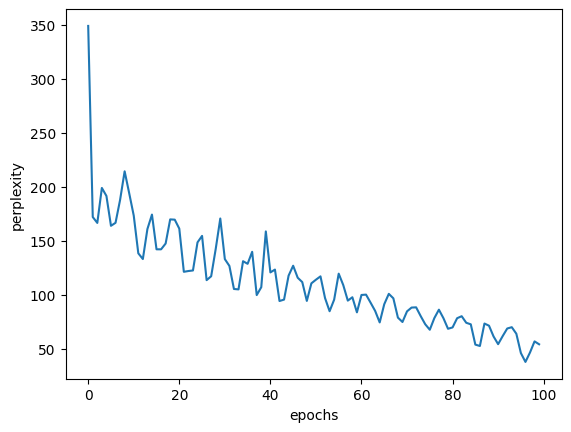

In [11]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from common.optimizer import SGD
from nndataset import ptb

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5 
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus_size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
                time_idx += 1
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    ppl = np.exp(total_loss / loss_count)
    print("epoch %d, perplexity %.2f" % (epoch + 1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

In [14]:
import sys

sys.path.append('..')
import matplotlib.pyplot as plt
from common.optimizer import SGD
from nndataset import ptb
from common.trainer import RnnlmTrainer

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus_size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

trainer = RnnlmTrainer(model, optimizer)
trainer.fit(xs, ts, max_epoch, batch_size, time_size)


corpus_size: 1000, vocabulary size: 418
| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 416.71
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 402.98
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 306.05
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 233.46
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 215.24
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 211.48
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 201.84
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 202.41
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 195.48
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.95
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.34
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 188.73
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 191.56
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 186.48
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 185.82
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 189.20
| epoch 17 |  iter 1 / 19 | time 0[s] | p